# Steered MD in BioSimSpace

Once the steered MD simulation has finished, we can extract snapshots that sample a wider range of conformational space than would be easily achievable in equilibrium.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import BioSimSpace as BSS
import os

## Plot steering output

PLUMED outputs a file with the CV value that was used for steering, so we can see the progression during the simulation:

In [2]:
steering_output_file = 'data/COLVAR'

In [3]:
df = pd.read_csv(steering_output_file, sep=' ', comment='#', skipinitialspace=1, names=['time/ns', 'rmsd', 'bias'])
df['time/ns'] = df['time/ns']/1000
df['rmsd'] = df['rmsd']*10
df.set_index('time/ns', inplace=True)

(0.0, 152.0)

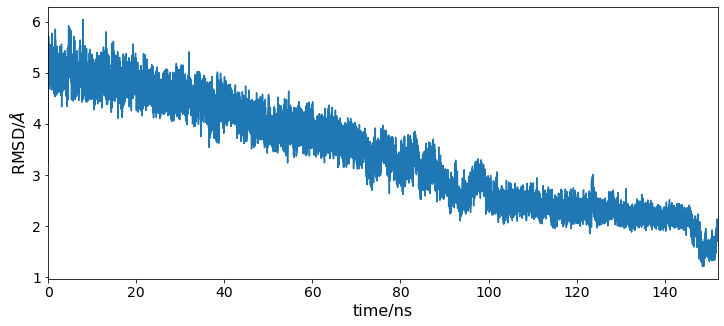

In [4]:
ax = df['rmsd'].plot(figsize=(12,5))
ax.set_ylabel('RMSD/$\AA$')
ax.set_xlim(0, 152)

## Extract snapshots

In this case we will be extracting 100 evenly spaced snapshots to be used as starting points for the seeded MD simulations.

In [5]:
snapshot_dir = '/home/adele/Documents/PTP1B-GROMACS/snapshots'
if not os.path.exists(snapshot_dir):
    os.mkdir(snapshot_dir)

Get frame indices for snapshots. Note that the end point selected is not the end of the simulation, but the end of the steering part.

In [5]:
number_of_snapshots = 100
frames = np.linspace(0, 30000, number_of_snapshots, dtype=int)

Check that the snapshots roughly even sample the RMSD range:

(0.0, 152.0)

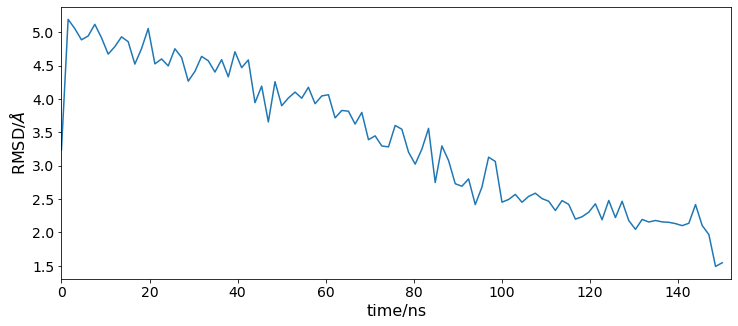

In [17]:
ax = df['rmsd'].iloc[frames].plot(figsize=(12,5))
ax.set_ylabel('RMSD/$\AA$')
ax.set_xlim(0, 152)

Save each snapshot as a PDB:

In [13]:
for i, index in enumerate(frames):
    frame = BSS.Trajectory.getFrame(trajectory='/home/adele/Documents/PTP1B-GROMACS/3500_150ns-2/gromacs.trr', topology = '/home/adele/Documents/PTP1B-GROMACS/3500_150ns-2/gromacs.gro', index=int(index))
    BSS.IO.saveMolecules(f'{snapshot_dir}/snapshot_{i+1}', frame, 'pdb')

These PDB files are to be used as starting points for 100 individual 100 ns simulations, starting with resolvation, minimisation and equilibration. This is very time consuming and best done on an HPC cluster.